In [1]:
# Import necessary libraries
import cdflib
import xarray as xr

import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from tqdm import tqdm
from dateutil import parser
import datetime as dt
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/prasoon_utility_programs')
import ecef_geodetic

In [2]:
path = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Soumya_GRACE_Fountain_effect/'

f = 'GRACE_data/df_sel.csv'
df = pd.read_csv(path+f)
print(df.columns)

time = [parser.parse(i) for i in df['index']]
df['gps_time'] = time
df = df.drop(['index', 'qualflg', 'xpos_err', 'xvel', 'xvel_err', 'ypos_err', 'yvel', 'yvel_err', 'zpos_err', 'zvel', 'zvel_err'], axis=1)
print(df.columns)

Index(['index', 'alt', 'gps_time', 'lat', 'lon', 'qualflg', 'xpos', 'xpos_err',
       'xvel', 'xvel_err', 'ypos', 'ypos_err', 'yvel', 'yvel_err', 'zpos',
       'zpos_err', 'zvel', 'zvel_err', 'mlt'],
      dtype='object')
Index(['alt', 'gps_time', 'lat', 'lon', 'xpos', 'ypos', 'zpos', 'mlt'], dtype='object')


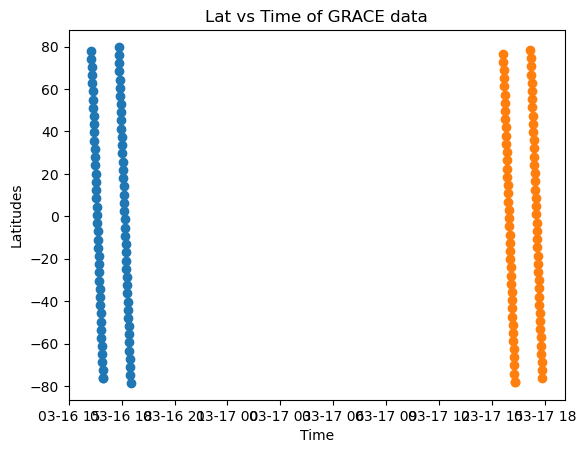

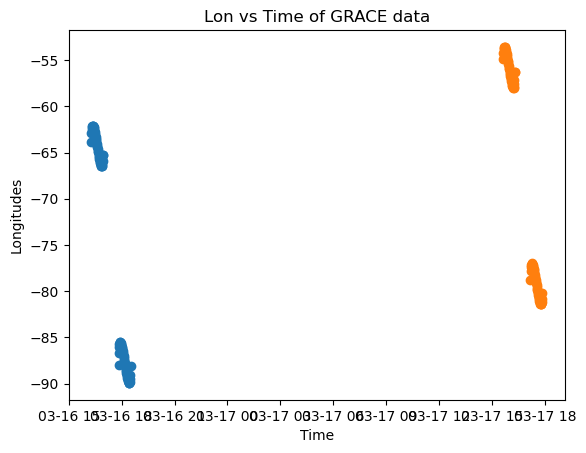

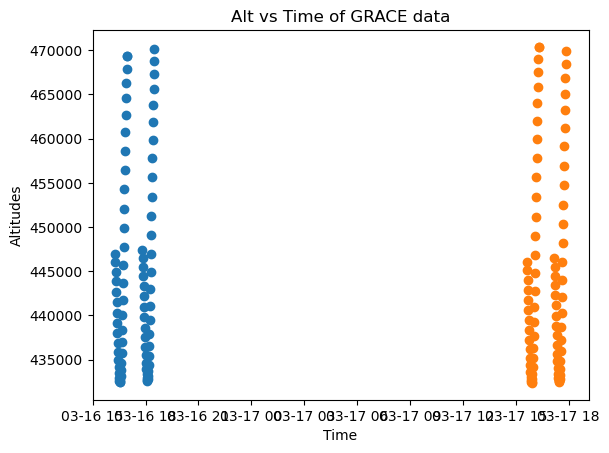

In [3]:
grace_pos1 = df[((df.gps_time > parser.parse('16-03-2013 12:00:00')) & (df.gps_time < parser.parse('17-03-2013 00:00:00')))].reset_index(drop=True)
grace_pos2 = df[(df.gps_time > parser.parse('17-03-2013 12:00:00'))].reset_index(drop=True)

plt.figure()
plt.scatter(grace_pos1.gps_time, grace_pos1.lat)
plt.scatter(grace_pos2.gps_time, grace_pos2.lat)
plt.xlabel('Time')
plt.ylabel('Latitudes')
plt.title('Lat vs Time of GRACE data')
plt.show()

plt.figure()
plt.scatter(grace_pos1.gps_time, grace_pos1.lon)
plt.scatter(grace_pos2.gps_time, grace_pos2.lon)
plt.xlabel('Time')
plt.ylabel('Longitudes')
plt.title('Lon vs Time of GRACE data')
plt.show()

plt.figure()
plt.scatter(grace_pos1.gps_time, grace_pos1.alt)
plt.scatter(grace_pos2.gps_time, grace_pos2.alt)
plt.xlabel('Time')
plt.ylabel('Altitudes')
plt.title('Alt vs Time of GRACE data')
plt.show()

[42]


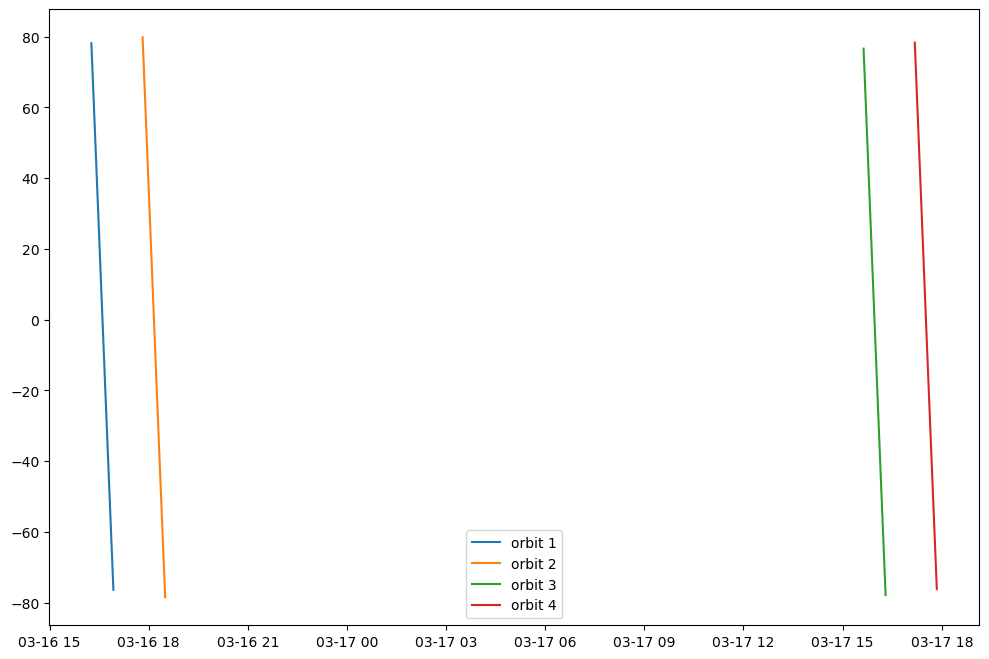

In [4]:
peaks, _ = find_peaks(grace_pos1.lat.abs())
print(peaks)
orbit1 = grace_pos1[grace_pos1.index < peaks[0]].reset_index(drop=True)
orbit2 = grace_pos1[grace_pos1.index >= peaks[0]].reset_index(drop=True)

peaks, _ = find_peaks(grace_pos2.lat.abs())
orbit3 = grace_pos2[grace_pos2.index < peaks[0]].reset_index(drop=True)
orbit4 = grace_pos2[grace_pos2.index >= peaks[0]].reset_index(drop=True)

orbits = [orbit1, orbit2, orbit3, orbit4]

plt.figure(figsize=(12,8))
plt.plot(orbit1.gps_time, orbit1.lat, label='orbit 1')
plt.plot(orbit2.gps_time, orbit2.lat, label='orbit 2')
plt.plot(orbit3.gps_time, orbit3.lat, label='orbit 3')
plt.plot(orbit4.gps_time, orbit4.lat, label='orbit 4')
plt.legend()

In [44]:
path = '/home/pxv220016/scratch/los_tec_data/17_storm_collection/'
files = ['gps130316g.003.hdf5.txt','gps130317g.004.hdf5.txt']

grnd_t = []

for f in tqdm(files):
    df = pd.read_csv(path+f, sep=r'\s+')
    d = [dt.datetime(y,m,d,h,mi,s) for y,m,d,h,mi,s in zip(df.YEAR, df.MONTH, df.DAY, df.HOUR, df.MIN, df.SEC)]
    df['DT'] = d
    df = df.drop(['RECNO','KINDAT','KINST','UT1_UNIX','UT2_UNIX','YEAR','MONTH','DAY','HOUR','MIN','SEC','DTEC'], axis=1)
    if 'GDALT' in df.columns:
        df = df.drop(['GDALT'],axis=1)
    #df = df[(df.GDLAT >= -60) & (df.GDLAT <= 60)].reset_index(drop=True)
    grnd_t.append(df)

grnd_tec = pd.concat([grnd_t[0], grnd_t[1]], axis=0)
grnd_tec.reset_index(drop=True, inplace=True)
print(grnd_tec)


100%|█████████████████████████████████████████████| 2/2 [00:39<00:00, 19.59s/it]


         GDLAT   GLON       TEC                  DT
0        -89.0 -155.0  13.70000 2013-03-16 00:02:30
1        -89.0 -154.0  13.60000 2013-03-16 00:02:30
2        -89.0 -153.0  13.40000 2013-03-16 00:02:30
3        -89.0 -152.0  13.90000 2013-03-16 00:02:30
4        -89.0 -151.0  13.80000 2013-03-16 00:02:30
...        ...    ...       ...                 ...
8054312   87.0  -17.0   3.53714 2013-03-17 23:57:30
8054313   88.0  -47.0   4.40801 2013-03-17 23:57:30
8054314   88.0  -44.0   4.37257 2013-03-17 23:57:30
8054315   88.0  -40.0   4.44498 2013-03-17 23:57:30
8054316   88.0  -38.0   4.46184 2013-03-17 23:57:30

[8054317 rows x 4 columns]


In [66]:
grnd_tec = grnd_tec[(grnd_tec.DT.dt.hour >= 15) & (grnd_tec.DT.dt.hour < 20)].reset_index(drop = True)
# All the ground tec data is at the intervals of 5 minutes
#print(grnd_tec.GLON.unique())

gg_tec = []
for o in orbits:
    for i in range(len(o.lat)):
        lat_s = int(o.lat[i])
        lon_s = int(o.lon[i])
        time_s = 

[   7.    8.    9.   10.   11.   12.   13.   14.   15.   16.   17.   53.
   57.   61.   68.   74.   77.   83.   86.   90.   93.   95. -171. -170.
 -169. -168. -167. -166. -164. -163. -162. -120. -119. -118. -117. -116.
 -115. -114. -113.  -85.  -84.  -83.  -82.  -81.  -80.  -79.  -78.  -77.
  -76.  -75.  -61.  -60.  -59.  -58.  -57.  -56.  -55.   76.  161.  162.
  163.  164.  165.  166.  167.  168.  169. -179. -177. -176. -175. -174.
 -172. -165.  -86.   18.   19.  134.  135.  136.  142.  143.  144.  178.
  179. -180. -178. -126. -125. -124. -123. -122. -121. -103. -102. -101.
  -74.  -73.  -46.  -45.  -41.   20.   21.   22.   23.   24.   25.   26.
   27.  127.  150.  151.  152.  153.  154.  155.  156.  157.  158.  159.
  175.  176.  177. -173. -109. -108. -107.  -72.  -71.  -70.  -69.  -68.
  -40.  -39.  -31.  -30.  -19.  -18.  124.  126.  128.  129.  170.  171.
  172.  174. -160. -159. -158. -157. -156. -155. -154. -153. -152. -149.
 -148. -147. -146. -132. -131. -110.  -95.  -94.  -

In [61]:
print(orbits[0].columns)
print(orbits[0].gps_time.unique())


Index(['alt', 'gps_time', 'lat', 'lon', 'xpos', 'ypos', 'zpos', 'mlt'], dtype='object')
['2013-03-16T16:16:00.000000000' '2013-03-16T16:17:00.000000000'
 '2013-03-16T16:18:00.000000000' '2013-03-16T16:19:00.000000000'
 '2013-03-16T16:20:00.000000000' '2013-03-16T16:21:00.000000000'
 '2013-03-16T16:22:00.000000000' '2013-03-16T16:23:00.000000000'
 '2013-03-16T16:24:00.000000000' '2013-03-16T16:25:00.000000000'
 '2013-03-16T16:26:00.000000000' '2013-03-16T16:27:00.000000000'
 '2013-03-16T16:28:00.000000000' '2013-03-16T16:29:00.000000000'
 '2013-03-16T16:30:00.000000000' '2013-03-16T16:31:00.000000000'
 '2013-03-16T16:32:00.000000000' '2013-03-16T16:33:00.000000000'
 '2013-03-16T16:34:00.000000000' '2013-03-16T16:35:00.000000000'
 '2013-03-16T16:36:00.000000000' '2013-03-16T16:37:00.000000000'
 '2013-03-16T16:38:00.000000000' '2013-03-16T16:39:00.000000000'
 '2013-03-16T16:40:00.000000000' '2013-03-16T16:41:00.000000000'
 '2013-03-16T16:42:00.000000000' '2013-03-16T16:43:00.000000000'
 '

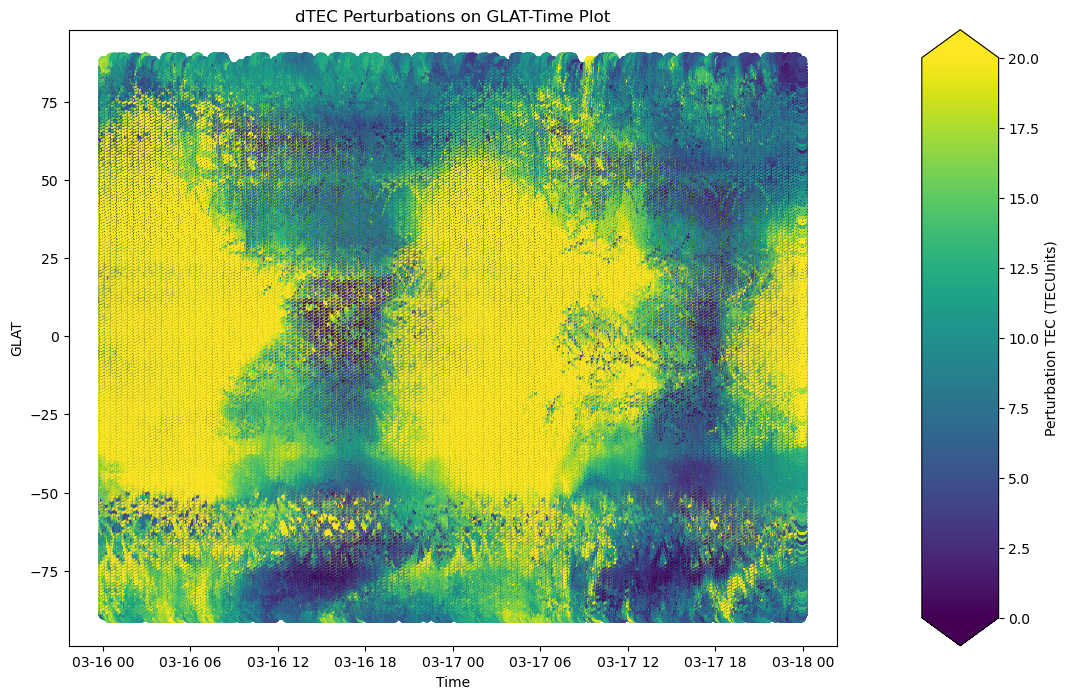

In [24]:
fig = plt.figure(figsize=(12,8))
specs = fig.add_gridspec(1, 2, width_ratios=[1,0.1])
ax = []
ax.append(fig.add_subplot(specs[0, 0]))
c = ax[0].scatter(los[0].DT, los[0].GDLAT, c=los[0].TEC, vmax=20, vmin=0)
ax[0].scatter(los[1].DT, los[1].GDLAT, c=los[1].TEC, vmax=20, vmin=0)
ax[0].set_title('VTEC on GLAT-Time Plot')
ax[0].set_ylabel('GLAT')
ax[0].set_xlabel('Time')

cbar_ax = fig.add_subplot(specs[0,1])
cbar = fig.colorbar(c, cax=cbar_ax, label='VTEC (TECUnits)', extend='both')
fig.show()

# Verify with ESA Grace data - Aaron's Project

In [5]:
# Import necessary libraries
import cdflib
import xarray as xr

import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from tqdm import tqdm
from dateutil import parser
import datetime as dt
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/prasoon_utility_programs')
import ecef_geodetic

In [12]:
path = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Soumya_GRACE_Fountain_effect/GRACE_data/ESA_GRACE_data/'

date = ['20130315', '20130316', '20130317']

grace = pd.DataFrame(columns=['Latitude', 'Longitude', 'date', 'LT'])

for d_n in tqdm(date):
    print(d_n)
    g_num = ['1', '2']
    for g in g_num:
        print(g)
        f = 'GR_OPER_TEC' + g + 'TMS_2F_' + d_n + 'T000000_' + d_n + 'T235959_0101.cdf'

        data = xr.Dataset()
        d = cdflib.CDF(path + f)
    
        step = range(len(d['Timestamp']))
        
        for var_name in d.cdf_info().zVariables:
            
            var_data = d[var_name]
    
            if var_name == 'DCB' or var_name == 'DCB_Error' :
                data[var_name] = d[var_name]
            
            elif type(var_data[0]) == np.ndarray:
                var_name1 = var_name + '_X'
                var_name2 = var_name + '_Y'
                var_name3 = var_name + '_Z'
                data[var_name1] = ('step', [i for i,j,k in var_data], {'step': step})
                data[var_name2] = ('step', [j for i,j,k in var_data], {'step': step})
                data[var_name3] = ('step', [k for i,j,k in var_data], {'step': step})
    
            else:
                data[var_name] = ('step', var_data, {'step': step})
    
    
        d0 = pd.Timestamp(f.split('_')[-2])  # Aaron changed how date_0 was calculated.
        date = [d0 + pd.Timedelta(milliseconds = (i - data.Timestamp[0].values)) for i in data.Timestamp.values]
        data['date'] = ('step', [i for i in date], {'step': step})
        lt = ecef_geodetic.ut_to_lt(date, data['Longitude'].values)
        data['LT'] = ('step', lt, {'step':step})

        df = data.to_dataframe()
        df = df.drop(['Timestamp', 'GPS_Position_X', 'GPS_Position_Y', 'GPS_Position_Z', 'Radius', 'LEO_Position_X', 'LEO_Position_Y', 
                      'LEO_Position_Z', 'PRN', 'L1', 'L2', 'P1', 'P2', 'S1_C_N0', 'S2_C_N0', 'Absolute_STEC', 'Absolute_VTEC', 
                      'Elevation_Angle', 'Relative_STEC', 'Relative_STEC_RMS', 'DCB', 'DCB_Error'], axis = 1)

        df = df[(df.date.dt.hour >= 15) & (df.date.dt.hour < 19)].reset_index(drop=True)
        #print(df)

        #grace.append(df)
        grace = pd.concat([grace, df], axis = 0)



  0%|                                                     | 0/3 [00:00<?, ?it/s]

20130315
1
2


 33%|███████████████                              | 1/3 [00:12<00:24, 12.03s/it]

20130316
1
2


 67%|██████████████████████████████               | 2/3 [00:23<00:11, 11.95s/it]

20130317
1
2


100%|█████████████████████████████████████████████| 3/3 [00:36<00:00, 12.07s/it]


In [13]:
print(df.columns)

Index(['Latitude', 'Longitude', 'date', 'LT'], dtype='object')


In [14]:
eas_orbit1 = grace[(grace.date > min(orbit1.gps_time)) & (grace.date < max(orbit1.gps_time))].reset_index(drop=True)
eas_orbit2 = grace[(grace.date > min(orbit2.gps_time)) & (grace.date < max(orbit2.gps_time))].reset_index(drop=True)
eas_orbit3 = grace[(grace.date > min(orbit3.gps_time)) & (grace.date < max(orbit3.gps_time))].reset_index(drop=True)
eas_orbit4 = grace[(grace.date > min(orbit4.gps_time)) & (grace.date < max(orbit4.gps_time))].reset_index(drop=True)


AttributeError: module 'matplotlib.pyplot' has no attribute 'eas_orbit1'

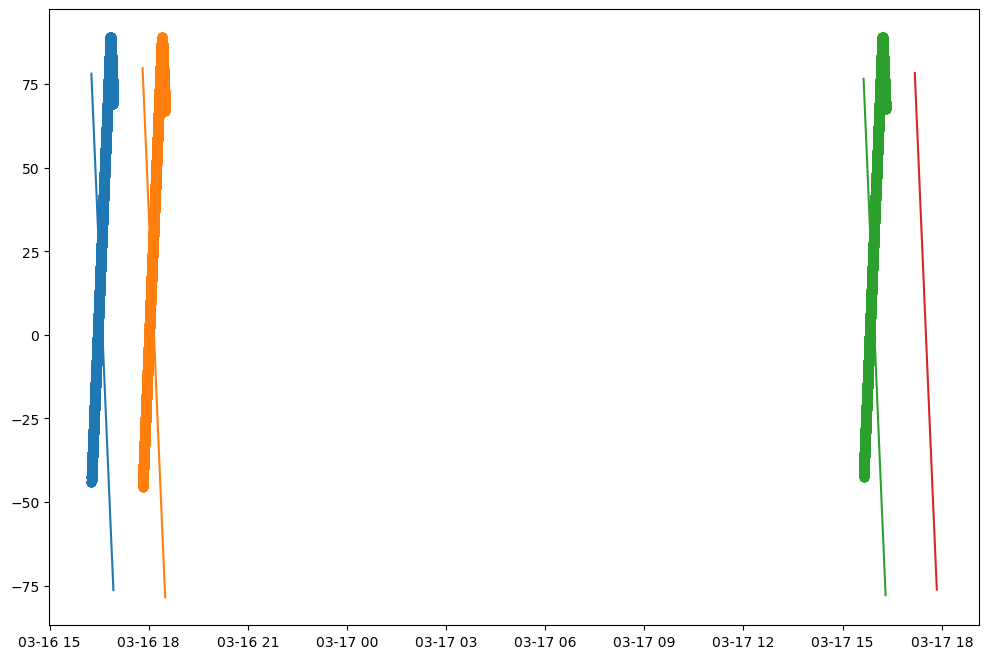

In [16]:
plt.figure(figsize=(12,8))
plt.plot(orbit1.gps_time, orbit1.lat, label = 'orbit 1')
plt.plot(orbit2.gps_time, orbit2.lat, label = 'orbit 2')
plt.plot(orbit3.gps_time, orbit3.lat, label = 'orbit 3')
plt.plot(orbit4.gps_time, orbit4.lat, label = 'orbit 4')
plt.scatter(eas_orbit1.date, eas_orbit1.Latitude, label = 'g1')
plt.scatter(eas_orbit2.date, eas_orbit2.Latitude, label = 'g2')
plt.scatter(eas_orbit3.date, eas_orbit3.Latitude, label = 'g3')
plt.eas_orbit1(eas_orbit4.date, eas_orbit4.Latitude, label = 'g4')
plt.xlabel('Time')
plt.ylabel('Latitude')
plt.title('Soumya-GRACE Data and ESA_Swarm-GRACE Data Orbits')
plt.legend()
plt.show()


# GITM-SAMI3 Result Validation

In [7]:
# Function for rays along Line of sight from Grace to GPS satellite

def line_of_sight_calc(start, end, #start and end pts
                       num_points=50, # number of points 
                       base = 4, # Adjust base of log to get required point density
                       spacing='log'): # currently supports log & linear
    # Calculate direction vector
    direction = np.array(end) - np.array(start)
    
    if spacing == 'log':
        # see below for a discussion on why I did this
        deltas = np.geomspace(0.00001, 1, num=num_points) ** (base/10)
    
    elif spacing == 'linear':
        deltas = np.linspace(0, 1, num=num_points)
        
    else:
        raise ValueError
    
    # Scale and translate values to fit the line segment
    points = [start + t * direction for t in deltas]

    return points

In [54]:

for o in orbits:
    a = [0]*len(o.alt)
    grace_coord = [o.lat, o.lon, o.alt]
    ground_coord = [o.xpos, o.ypos, a]
        
    ray = line_of_sight_calc(grace_coord, ground_coord)

    points = []
    for r in ray:
        lat_r, lon_r, alt_r = r
        x_r = []
        y_r = []
        z_r = []
        for la, lo, al in zip(lat_r, lon_r, alt_r):
            x, y, z = ecef_geodetic.spher_cart(la,lo,al)
            x_r.append(x)
            y_r.append(y)
            z_r.append(z)
        points.append(np.array([x_r, y_r, z_r]))

df_raypaths = pd.DataFrame()
df_raypaths['lat'] = points[:,:,0].flatten()
df_raypaths['lon'] = points[:,:,1].flatten()
df_raypaths['alt'] = points[:,:,2].flatten() / 1000


path = '/home/pxv220016/scratch/'
csv_name = path + 'multiorbit_data/single_orbit_los_' + str(orbit_num) + '.csv'
csv_raw_name = path + 'multiorbit_data/single_orbit_raw_' + str(orbit_num) + '.csv'
df_raypaths.to_csv(csv_name, index=False)
df1.to_csv(csv_raw_name, index=False)

file_name = path + 'multiorbit_data/orbit_' + str(orbit_num)

SAMI3_ESMF_Regrid.main(sami_data_path='/home/pxv220016/scratch/2013-03-17_SAMI', 
                       dtime_sim_start='20130316',
                       cols='edens',
                       out_dir='/home/pxv220016/scratch/multiorbit_data',
                       custom_input_file=csv_name,
                       ESMF_DIR='/home/pxv220016/prasoon/data/SAMI3-GITM-python/esmf-8.4.0/apps/appsO/Linux.gfortran.64.openmpi.default/',
                       remake_files=True,
                       output_filename=file_name,
                         )

print('DONE...', orbit_num)

[array([[-114717.83566686,  370195.33433998,   90372.01760184,
         -67295.10878978,  376523.28822837, -149698.73485631,
         -29486.97719409,   27339.17352959, -105825.94677549,
         -47337.04846218, -114689.21172391,  182994.95116799,
          54842.08975696, -386777.35862592,  -29752.79177741,
         140237.07450722, -408197.60041836,   28214.50282476,
         117155.68025923,  -89527.10277582, -353546.81843851,
         381358.17307619,  283008.48244222,   11792.56464122,
        -234016.06864468,  154723.66424668, -294466.55813015,
          54805.26303012,    1545.41553855, -107922.95792202,
          49076.7217311 , -216864.8763202 ,    6366.04677495,
         262219.75127255,  134538.14944471,  146457.36878436,
         -44087.53360548, -339804.81126653, -423579.20893916,
         145037.90451201, -417857.66648783],
       [  60903.12662548,  -67180.20309248,  423054.83624967,
        -281931.28369487,   32808.37676439, -281814.08019594,
        -422638.70243551